# Introduction

This project utilizes the Yelp academic dataset found through https://www.yelp.com/dataset. It aims to use this dataset, which is a subset of the larger yelp dataset, and applies multiple clustering machine learning algorithms. Yelp is known as an industry leading company with millions of restaurant reviews, which provides us with an extensive and informative database for a restaurant recommendation engine. 

The original yelp academic dataset is split into 5 different JSON files. For our analysis, we used 1 of the original 5 files, business.json. The Business.json file has 59 different attributes and 188594 entries. However, the data is relatively sparse with many null entries for many of the attributes. 

# Data Cleaning

The first step we did was to convert the JSON files to a CSV file to make it easier to process. The yelp dataset has information on businesses other than restaurants. To filter this dataset to retrieve only businesses that are restaurants out we removed any entries within the business.csv file with a null for restaurant takeout. We also removed any permanently closed restaurants and restaurants without a price range to make the final dataset we used to have less null values.

In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
#Determined which businesses were restaturants
businesses = pd.read_csv('yelp_academic_dataset_business.csv')
businesses.dropna(subset=['attributes.RestaurantsTakeOut'], inplace=True)
businesses.dropna(subset=['attributes.RestaurantsPriceRange2'],inplace=True)
businesses.head()

,address,attributes.AcceptsInsurance,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,...,hours.Wednesday,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,...,11:0-21:0,1,51.091813,-114.031675,Minhas Micro Brewery,NaN,T2E 6L6,24,4.0,AB
1,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN,False,NaN,...,NaN,0,35.960734,-114.939821,CK'S BBQ & Catering,NaN,89002,3,4.5,NV
2,1335 rue Beaubien E,NaN,NaN,beer_and_wine,"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,NaN,...,10:0-22:0,0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
5,"20235 N Cave Creek Rd, Ste 1115",NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,...,5:30-20:0,1,33.671375,-112.030017,The Coffee Bean & Tea Leaf,NaN,85024,63,4.0,AZ
7,"3417 Derry Road E, Unit 103",NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,43.712946,-79.632763,Thai One On,Ridgewood,L4T 1A8,7,2.0,ON


# Data Selection

The goal of this project is to cluster based on latitude and longitude in a given city to find which categories of food is more popular. Therefore the attributes we selected are business_id, name, categories, latitude, longitude, and city from the businesses dataset.

In [3]:
cleaned_businesses = businesses[['business_id','name','categories','latitude','longitude','city']]
cleaned_businesses.head()

,business_id,name,categories,latitude,longitude,city
0,Apn5Q_b6Nz61Tq4XzPdf9A,Minhas Micro Brewery,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",51.091813,-114.031675,Calgary
1,AjEbIBw6ZFfln7ePHha9PA,CK'S BBQ & Catering,"Chicken Wings, Burgers, Caterers, Street Vendo...",35.960734,-114.939821,Henderson
2,O8S5hYJ1SMc8fA4QBtVujA,La Bastringue,"Breakfast & Brunch, Restaurants, French, Sandw...",45.540503,-73.599300,Montréal
5,45bWSZtniwPRiqlivpS8Og,The Coffee Bean & Tea Leaf,"Coffee & Tea, Food",33.671375,-112.030017,Phoenix
7,6OuOZAok8ikONMS_T3EzXg,Thai One On,"Restaurants, Thai",43.712946,-79.632763,Mississauga


In [4]:
#Put the cleaned dataframe into csv so it can be used in another notebook if needed
cleaned_businesses.to_csv('cleaned_businesses.csv')
data = cleaned_businesses

# Clustering

In [5]:
#common category tags to ignore
ignore = ["Restaurants", "Food", "Nightlife"]
#prints the count of unique items in array label
def label_count(labels):

    lab_count = dict()

    for x in labels:
        if x in lab_count:
            lab_count[x] += 1
        else:
            lab_count[x] = 1

    print("dictionary length:", len(lab_count))
    for k, v in lab_count.items():
        print(k,"\t",v)
    return


In [6]:
#prints the top 5 categories for each cluster
#grouped is an dataframe with "clusters" from 0 to n and "categories"
#n is the number of clusters
def print_Categories(grouped, n):

    cat_list = [dict() for x in range(n)]

    for index, row in grouped.iterrows():
        for x in range(n):
            if (row["clusters"] == x):
                cats = row["categories"]
                words = [x.strip() for x in cats.split(",")]
                for word in words:
                    if word not in ignore:
                        if word in cat_list[x]:
                            cat_list[x][word] += 1
                        else:
                            cat_list[x][word] = 1
                break


    for x in range(n):
        print("\n\n", x , "category dictionary")
        sorted_x = sorted(cat_list[x].items(), key=lambda kv: kv[1])
        sorted_x = list(reversed(sorted_x))
        for y in range(5):
            if(y < len(sorted_x)):
                print(sorted_x[y])
    return

In [13]:
#Prompt for city name. Choose from list below.
#List of cities available 
data['city'].unique()
city = input("Enter a city ")

Enter a city Toronto


In [20]:
data = cleaned_businesses.loc[cleaned_businesses['city'] == city]
count_row = data.shape[0] 
train_index = int(count_row * .70)

5330

In [21]:
#randomize order of data
data = data.sample(frac = 1, random_state = 1)

#separate into train and test data
train = data.iloc[0:train_index,:]

#use all data for agg, DBScan, Birch
test = data.iloc[train_index:,:]

In [22]:
#separate the checkin data to cluster on
lat_lon = train.iloc[:, 3:5]
lat_lon = lat_lon.fillna(0)

full_lat_lon = data.iloc[:, 3:5]
full_lat_lon = full_lat_lon.fillna(0)

## K-means

First we clustered based on the 

In [23]:
from sklearn.cluster import KMeans

In [28]:
n=8
full = KMeans(n_clusters = n, random_state = 0).fit(full_lat_lon)
cluster = KMeans(n_clusters = n, random_state = 0).fit(lat_lon)
full_labels = full.labels_
labels = cluster.labels_

In [29]:
#display the clusters
print("\n\nClusters:")
label_count(labels)

#attach the clusters to other data
train["clusters"] = labels
info = ["categories", "name", "clusters"]
grouped = train[info]
grouped = grouped.fillna("")

info = ["latitude", "longitude", "clusters"]
#use for visualization
visualization_data = train[info]
visualization_data = visualization_data.fillna("")

#print(grouped.head())
#display categories within clusters
print_Categories(grouped, n)



Clusters:
dictionary length: 8
3 	 2158
6 	 638
2 	 249
4 	 276
1 	 974
0 	 428
7 	 158
5 	 449


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  




 0 category dictionary
('Chinese', 117)
('Coffee & Tea', 34)
('Indian', 32)
('Fast Food', 30)
('Desserts', 29)


 1 category dictionary
('Bars', 143)
('Coffee & Tea', 141)
('Breakfast & Brunch', 96)
('Italian', 82)
('Canadian (New)', 79)


 2 category dictionary
('Coffee & Tea', 35)
('Chinese', 33)
('Japanese', 31)
('Korean', 29)
('Desserts', 26)


 3 category dictionary
('Coffee & Tea', 310)
('Bars', 259)
('Sandwiches', 195)
('Canadian (New)', 185)
('Breakfast & Brunch', 166)


 4 category dictionary
('Coffee & Tea', 42)
('Bars', 26)
('Cafes', 25)
('Breakfast & Brunch', 23)
('Specialty Food', 23)


 5 category dictionary
('Coffee & Tea', 49)
('Italian', 45)
('Japanese', 41)
('Sushi Bars', 36)
('Breakfast & Brunch', 33)


 6 category dictionary
('Coffee & Tea', 74)
('Bars', 70)
('Breakfast & Brunch', 55)
('Canadian (New)', 54)
('Pizza', 48)


 7 category dictionary
('Vietnamese', 16)
('Coffee & Tea', 15)
('Mediterranean', 14)
('Fast Food', 14)
('Middle Eastern', 13)


In [30]:
import matplotlib.pyplot as plt

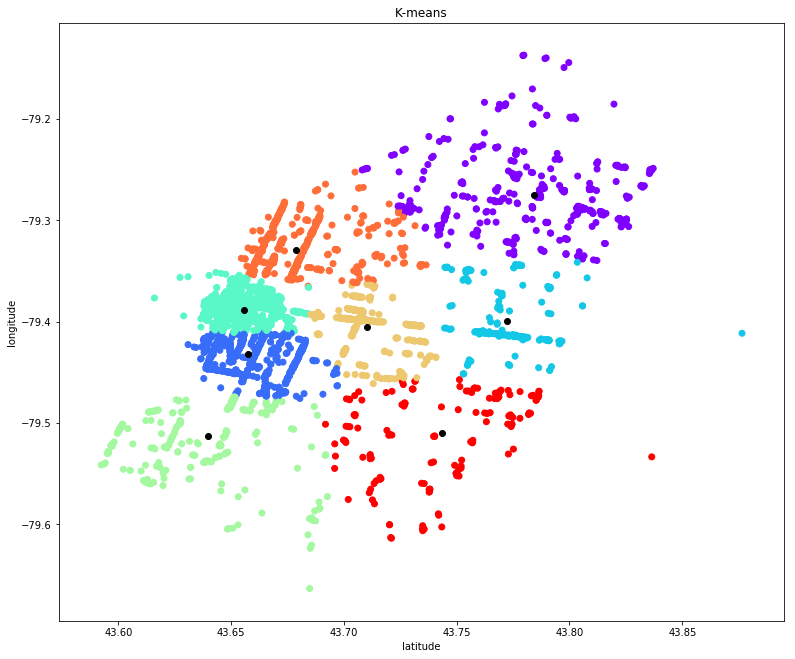

In [31]:
plt.figure(figsize=(13, 11))  
plt.scatter(train['latitude'], train['longitude'], c=train["clusters"], cmap='rainbow')    
plt.scatter(cluster.cluster_centers_[:,0] ,cluster.cluster_centers_[:,1], color='black') 
plt.figure(1, figsize=(12,2))
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('K-means')
plt.show()


## Agglomerative 